## Extracting Dihedral Angles at Triple Junctions from Segmentation Stacks

### Prep

In [4]:
### Imports
import scipy.interpolate as scipolate
import scipy.spatial.distance as sd
import itertools
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from ipywidgets import interact

from mpl_toolkits.mplot3d import Axes3D

In [5]:
### Load input

im = io.imread('../../../ForceInferenceProject/Data/Generated/three_intersecting_spheres_aniso.tif')
print(im.dtype, im.shape)

uint8 (200, 400, 400)


In [6]:
### Show input segmentations

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    plt.figure(figsize=(8,8))
    plt.imshow(im[z], cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

### Identifying Object Outlines

In [7]:
### Identify outlines by comparing shifted images

# Pad the image by 1 voxel on all sides
im_pad = np.pad(im, 1, mode='reflect')

# Get possible shifts in all directions
shifts = itertools.product([0,1], repeat=3)

# Check and accumulate differences in shifts
outlines = np.zeros_like(im, dtype=np.bool)
for shift in shifts:
    zs0, ys0, xs0 = [slice(1, None) if s else slice(None) for s in shift]
    zs1, ys1, xs1 = [slice(None,-1) if s else slice(None) for s in shift]
    comparison = im_pad[zs0, ys0, xs0] != im_pad[zs1, ys1, xs1]
    outlines  += comparison[:im.shape[0],  :im.shape[1],  :im.shape[2]]
    outlines  += comparison[-im.shape[0]:, -im.shape[1]:, -im.shape[2]:]  # Symmetry
    
# Re-annotate the cell identities
outlines_id = outlines * im

# Report
print(outlines.dtype, outlines.shape)
print(outlines_id.dtype, outlines_id.shape)

bool (200, 400, 400)
uint8 (200, 400, 400)


In [8]:
### Show identified outlines

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

### Identifying Triple Edges and Triple Junctions

In [9]:
### Find coordinates of all voxels involved in triple junctions

# Get coordinates of all cell outline voxels
OCs = np.array(np.where(outlines)).T  # OCs <- "Outline Coordinates"

# Go through outline coordinates (oc) and find TEs
TEs = []  # TEs <- "Triple Edes"
for OC in OCs:
    selection = im_pad[OC[0]+1:OC[0]+3, OC[1]+1:OC[1]+3, OC[2]+1:OC[2]+3]
    if len(set(selection.flatten())) == 3:
        TEs.append(OC+0.5)
        
# Convert TE list to numpy array
TEs = np.array(TEs)

In [10]:
### Build a dict of TJs structured as: {tuple(cell1_ID, cell2_ID, cell3_ID) : array(TEs, Dimensions)}

# Prepare defaultdict
from collections import defaultdict
TJs = defaultdict(lambda : [[],[],[]])  # TJs <- "Triple Junctions"

# Go through TEs, create IDs, assign coordinates to IDs
for TE in TEs:
    selection = im_pad[np.int(TE[0])+1:np.int(TE[0])+3, 
                       np.int(TE[1])+1:np.int(TE[1])+3, 
                       np.int(TE[2])+1:np.int(TE[2])+3]
    TJ_ID = tuple(sorted(set(selection.flatten())))
    TJs[TJ_ID][0].append(TE[0])
    TJs[TJ_ID][1].append(TE[1])
    TJs[TJ_ID][2].append(TE[2])

# Convert TJ lists to numpy arrays
for key in TJs.keys():
    TJs[key] = np.array(TJs[key]).T

In [11]:
### Show identified TJs on image stack

@interact(z=(0, im.shape[0]-1, 1))
def show_stack(z=im.shape[0]//2):
    
    # Prep and plot image
    plt.figure(figsize=(8,8))
    plt.imshow(outlines_id[z], cmap='gray')
    
    # For each TJ...
    for TJ_num,TJ_ID in enumerate(TJs.keys()):
        
        # Get the TJs TEs in the selected z plane
        TEs_in_plane = TJs[TJ_ID][np.floor(TJs[TJ_ID][:,0])==z]
        
        # Plot the points (note the curios way of setting the color!)
        plt.scatter(TEs_in_plane[:, 2], TEs_in_plane[:, 1],
                    c=[TJ_num for _ in range(TEs_in_plane.shape[0])], 
                    cmap='hsv', vmin=0, vmax=len(TJs), s=20)
        
    # Finish
    plt.show()

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

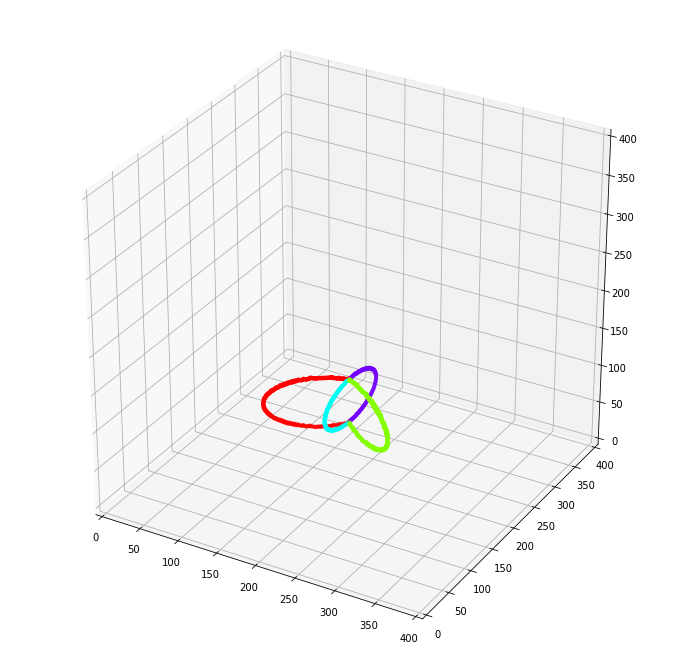

In [12]:
### Show identified TJs as 3D scatter

# Prepare the plot
fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(111, projection='3d')

# Plot each TJ in a different color
for TJ_num,TJ_ID in enumerate(TJs.keys()):
    ax.scatter(TJs[TJ_ID][:,2], TJs[TJ_ID][:,1], TJs[TJ_ID][:,0],
               c=[TJ_num for _ in range(TJs[TJ_ID].shape[0])], 
               cmap='hsv', vmin=0, vmax=len(TJs), s=10)

## Also show cell outlines [takes several seconds to render!]
#ax.scatter([c[2] for c in OCs],
#           [c[1] for c in OCs],
#           [c[0] for c in OCs],
#           c='gray', alpha=0.05, linewidth=0, s=5)

# Axis limits
ax.set_xlim([0,400])
ax.set_ylim([0,400])
ax.set_zlim([0,400])  # NOTE: RESULT IS SQUASHED IF RESOLUTION IS NOT CONSIDERED!

# Finish
plt.show()

### Next Up: Spline Fitting

In [13]:
TJs.keys()

dict_keys([(0, 1, 2), (0, 1, 3), (1, 2, 3), (0, 2, 3)])

In [27]:
TJs[(0, 1, 2)].shape

(374, 3)

In [34]:
matrixTJ[374][2:]

IndexError: index 374 is out of bounds for axis 0 with size 374

In [40]:
l = [1,2,3]
print(len(l))
print(list(range(3)))

3
[0, 1, 2]


This is a quick description of the problem

We thought about these solutions:
- blah
- blah
    - no good because ...
    
We solved it like this:
- blah

In [47]:
chain_dists = []
for pos in range(matrixTJ.shape[0]-1):
    chain_dists.append(matrixTJ[pos,pos+1])

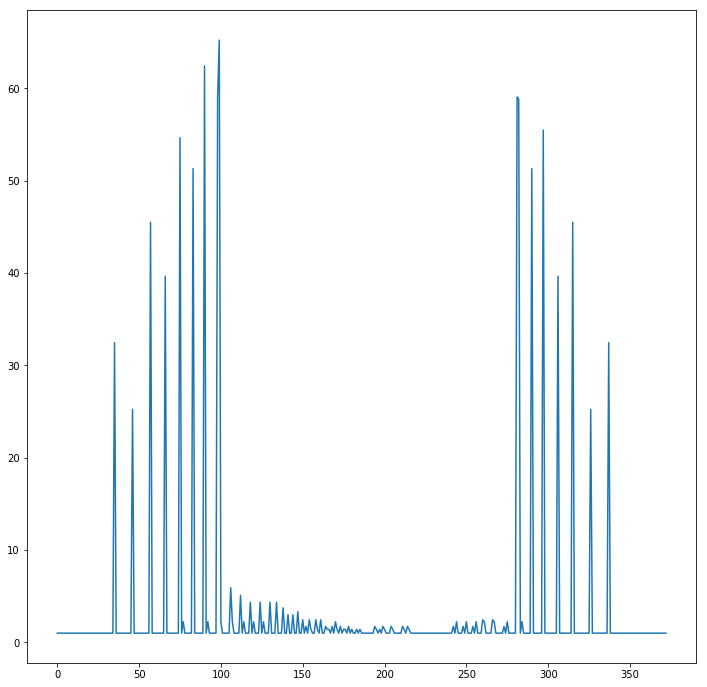

In [49]:
chain_dists = []
for pos in range(matrixTJ.shape[0]-1):
    chain_dists.append(matrixTJ[pos,pos+1])

plt.figure(figsize=(12,12))
plt.plot(chain_dists)
plt.show()

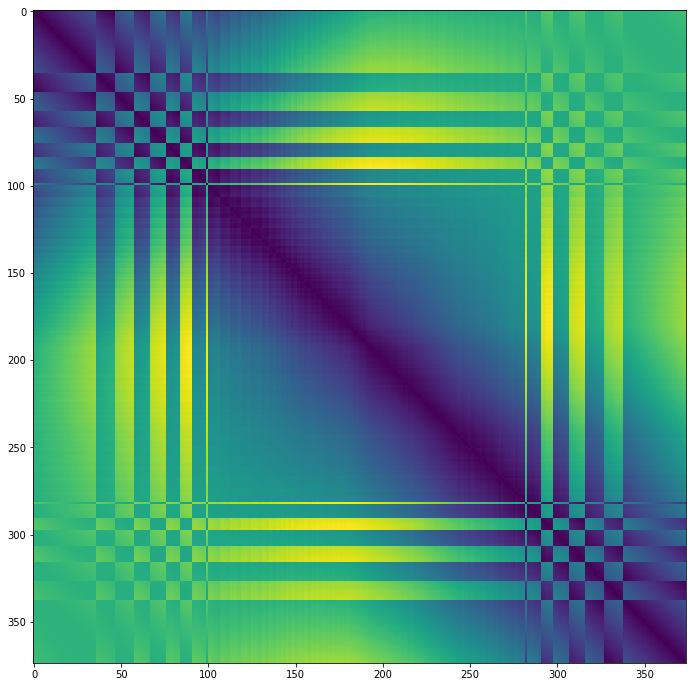

In [45]:
plt.figure(figsize=(12,12))
plt.imshow(matrixTJ)
plt.show()

In [42]:
matrixTJ = sd.squareform(sd.pdist(TJs[(0, 1, 2)], 'euclidean'))

In [ ]:
matrixTJ = sd.squareform(sd.pdist(TJs[(0, 1, 2)], 'euclidean'))
sortedTJs = []
for x in range(matrixTJ.shape[0]):
    w = np.argmin(matrixTJ[x][x+1:])
    while TJs[(0, 1, 2)][w] in sortedTJs:
        y = x+2
        w = np.argmin(matrixTJ[x][y:])
        y+=1
    sortedTJs.append(TJs[(0, 1, 2)][w])
sortedTJs

In [52]:
np.sort([4,5,6,-2,3,])

array([-2,  3,  4,  5,  6])

In [74]:
matrixTJ = sd.squareform(sd.pdist(TJs[(0, 1, 2)], 'euclidean'))
matrixTJ[np.eye(matrixTJ.shape[0], dtype=np.bool)] = np.inf
sortedTJs_indices = [0]

for x in range(matrixTJ.shape[0]):
    neighbors = np.argsort(matrixTJ[sortedTJs_indices[-1],:])
    for n in neighbors:
        if not n in sortedTJs_indices:
            sortedTJs_indices.append(n)
            break

sortedTJs = TJs[(0, 1, 2)][sortedTJs_indices]
print(sortedTJs_indices)
print(sortedTJs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 67, 68, 69, 70, 71, 72, 73, 74, 75, 84, 85, 86, 87, 88, 89, 90, 99, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 66, 65, 64, 63, 62, 61, 60, 59, 58, 83, 82, 81, 80, 77, 76, 79, 78, 98, 97, 96, 95, 92, 91, 94, 93, 106, 105, 104, 103, 100, 102, 101, 112, 111, 110, 107, 109, 108, 118, 117, 114, 113, 116, 115, 124, 123, 122, 121, 130, 129, 126, 125, 128, 127, 134, 133, 132, 131, 138, 137, 136, 135, 141, 140, 139, 144, 143, 142, 147, 146, 145, 150, 149, 148, 152, 151, 154, 153, 158, 157, 155, 156, 161, 159, 163, 162, 165, 168, 167, 170, 169, 173, 171, 174, 176, 178, 177, 180, 179, 181, 182, 183, 185, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 196, 197, 199, 201, 202, 203, 204, 206, 207, 208, 209, 210, 211, 213, 214, 212, 216, 217, 215, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,

In [75]:
matrix_sorted = sd.squareform(sd.pdist(sortedTJs), 'euclidean')

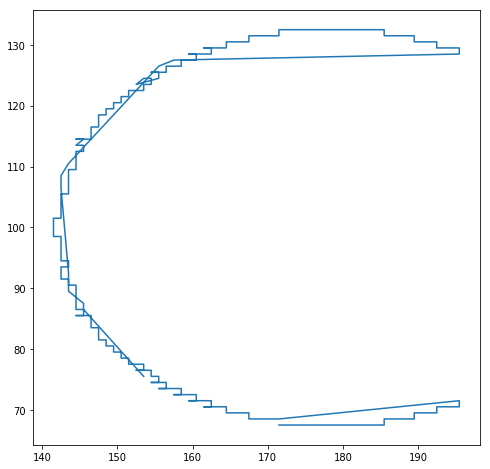

In [80]:
plt.figure(figsize = (8,8))
plt.plot(sortedTJs[:,1], 
         sortedTJs[:,0])
plt.show()

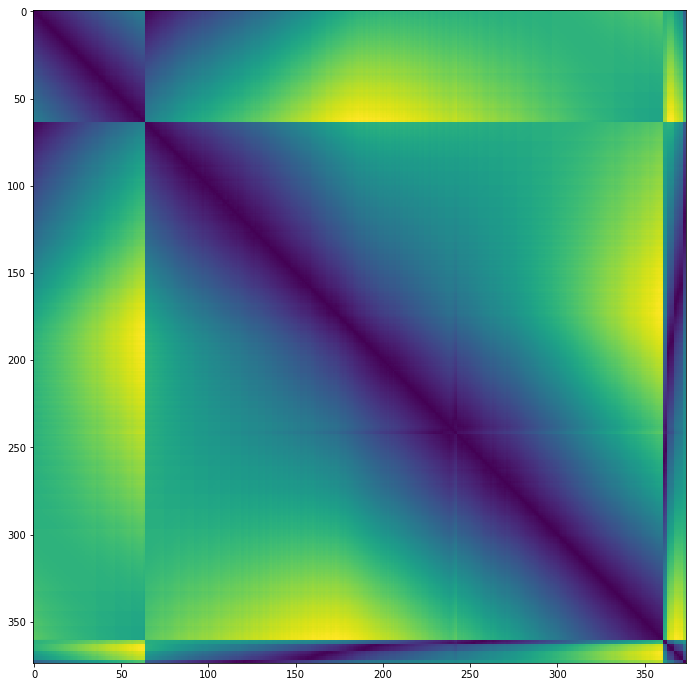

In [76]:
plt.figure(figsize=(12,12))
plt.imshow(matrix_sorted)
plt.show()

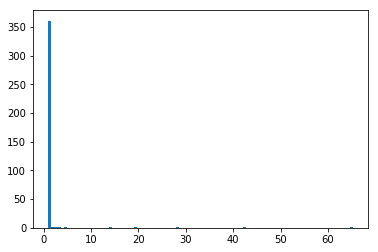

In [81]:
plt.hist(chain_dists_sorted, bins=100)
plt.show()

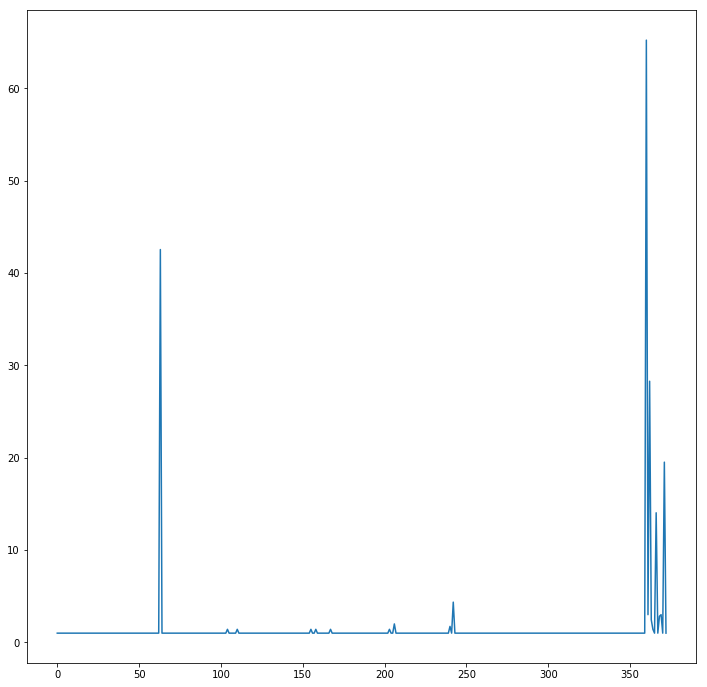

In [77]:
chain_dists_sorted = []
for pos in range(matrix_sorted.shape[0]-1):
    chain_dists_sorted.append(matrix_sorted[pos,pos+1])

plt.figure(figsize=(12,12))
plt.plot(chain_dists_sorted)
plt.show()

In [82]:
tckDict={}
fpDict={}
ierDict={}
msgDict={}
for TJ_ID in TJs.keys():
    tck, fp, ier, msg = scipolate.splprep(x = [TJs[TJ_ID][:,2],TJs[TJ_ID][:,1],
                                            TJs[TJ_ID][:,0]], k = 3, full_output=1, quiet=0)
    tckDict[TJ_ID] = tck
    fpDict[TJ_ID] = fp
    ierDict[TJ_ID] = ier
    msgDict[TJ_ID] = msg



In [83]:
splevDict = {}
for TJ_ID in TJs.keys():
    splevDict[TJ_ID] = scipolate.splev(x = np.linspace(0.0,1.0,100), tck = tckDict[TJ_ID][0])
    
    

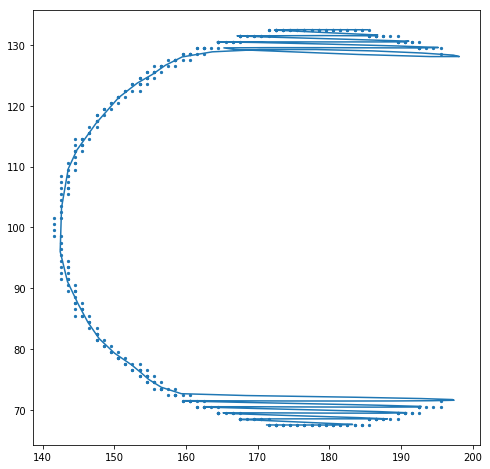

In [84]:
plt.figure(figsize = (8,8))
plt.scatter(TJs[(0, 1, 2)][:,1], 
            TJs[(0, 1, 2)][:,0],
            s=5)
plt.plot(splevDict[(0, 1, 2)][1],
            splevDict[(0, 1, 2)][2])
plt.show()

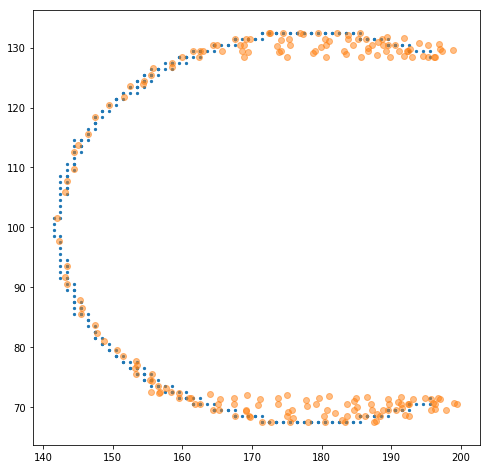

In [105]:
plt.figure(figsize = (8,8))
plt.scatter(TJs[(0, 1, 2)][:,1], 
            TJs[(0, 1, 2)][:,0],
            s=5)
plt.scatter(y_fine, z_fine, alpha=0.5)
plt.show()

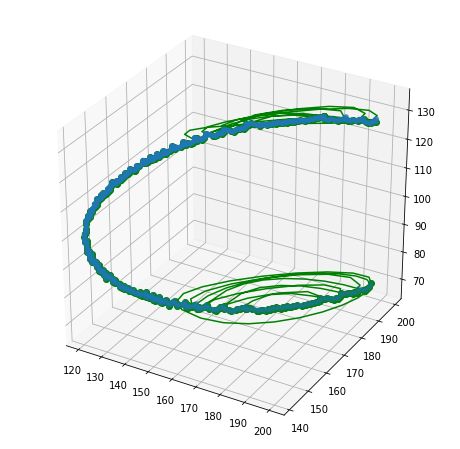

In [104]:
tck, u = scipolate.splprep([TJs[(0, 1, 2)][:,2],TJs[(0, 1, 2)][:,1],
                                            TJs[(0, 1, 2)][:,0]], s=2)
x_knots, y_knots, z_knots = scipolate.splev(tck[0], tck)
u_fine = np.linspace(0,1,200)
x_fine, y_fine, z_fine = scipolate.splev(u_fine, tck)

fig2 = plt.figure(figsize = (8,8))
ax3d = fig2.add_subplot(111, projection='3d')
#ax3d.plot(x_true, y_true, z_true, 'b')
#ax3d.plot(x_sample, y_sample, z_sample, 'r*')
ax3d.plot(x_knots, y_knots, z_knots, 'go')
ax3d.plot(x_fine, y_fine, z_fine, 'g')
ax3d.scatter(TJs[(0, 1, 2)][:,2], TJs[(0, 1, 2)][:,1], TJs[(0, 1, 2)][:,0])

fig2.show()
plt.show()

### TODO

- Brodland approach
    - Fit splines to outlines in the image plane
    - Identify angles in image plane for each TE *[sort of needed in both]*
    - Fit splines to TJs *[needed in both]*
    - Find normal plane to TJ-spline at each TE *[needed in both]*
    - Project image plane angles onto normal plane
    
    
- Better approach?
    - Fit splines to TJs *[needed in both]*
    - Find normal plane to TJ-spline at each TE *[needed in both]*
    - Identify angles in normal plane for each TE *[sort of needed in both]*